# Topic Modeling

We will walk through how to perform topic modeling on a corpus of Native American documents. We will use Latent Dirichlet Allocation (LDA), an unsupervised learning method in which documents are represented as a random mixture of latent topics, where each topic is a probability distribution over words. 

## Processing Corpus

In [1]:
#Set random seed for reproduction of code. 
import numpy as np
np.random.seed(42)

#Change working directory. 
import os
os.chdir("/Users/vickijtruong/Documents/DH199/Corpus")
all_files = os.listdir("/Users/vickijtruong/Documents/DH199/Corpus")
all_files.sort()
all_files.pop(0)
#print(all_files)
len(all_files)

295

In [2]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import string

#Import stop words. Edit as needed. 
stop_words = stopwords.words('english')
#more_stop = []
#stop_words = stop_words + more_stop

not_stopwords = ['i','we','you']
stop_words = set([word for word in stop_words if word not in not_stopwords])
#print(stop_words)

In [3]:
#Read each file into the working directory. Remove stop words, non-alphabetical terms, and punctuation. Append each processed file into the docs list. 
docs = []

for file in all_files:
    with open(file,'r') as f:
        text = f.read()        
        tokenized = word_tokenize(text)
        tokens_lower = [w.lower() for w in tokenized]
        filtered = [w for w in tokens_lower if not w in stop_words and w.isalpha()] 
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in filtered]
        stripped = list(filter(None, stripped))
        docs.append(stripped)
        
#print(docs)
len(docs)

295

## Creating the Model + Topics

### Create dictionary and bag of words corpus

In [4]:
from gensim import corpora, models, similarities

#Create dictionary of words. 
dictionary = corpora.Dictionary(docs)
#Filter out tokens that appear in less than 3 documents.
dictionary.filter_extremes(no_below=3) 
#print(dictionary)
#print(len(dictionary))

#Convert convert tokenized documents to vectors 
corpus = [dictionary.doc2bow(text) for text in docs]
#print(corpus)

#[[(dictionary[id],freq) for id, freq in cp]for cp in corpus]

### Determine optimal number of topics for LDA model. Compare coherence scores across different numbers of topics.

In [5]:
from gensim.models.coherencemodel import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state = 100, passes = 25, chunksize = 100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [6]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=15, step=1)

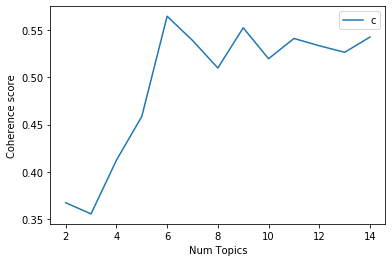

In [8]:
#Plot the graph of coherence scores across different number of topics (from 2 to 15).
import matplotlib.pyplot as plt
limit=15; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In this case, given the parameters of the model, the optimal number of topics is 6, since the coherence score is highest then.

### Performing LDA with optimal number of topics

In [5]:
#Parameter tuning will lead to different models. For this model, we use our corpus, dictionary, set a random state of 100 (akin to setting a seed for reproduction purposes), 11 topics (optimal number according to coherence scores), 25 passes (number of times the corpus is passed through for training), and chunk size of 100 (number of documents to be used in each training chunk).
lda = models.LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         random_state=100,
                         num_topics=6,
                         passes=25,
                         chunksize=100,
                         )
lda.show_topics()

[(0,
  '0.005*"troops" + 0.004*"captain" + 0.004*"major" + 0.004*"ohio" + 0.004*"militia" + 0.003*"six" + 0.003*"pay" + 0.003*"frontiers" + 0.003*"colonel" + 0.003*"officers"'),
 (1,
  '0.011*"georgia" + 0.010*"commissioners" + 0.004*"colonel" + 0.004*"council" + 0.003*"line" + 0.003*"limits" + 0.003*"cherokees" + 0.002*"mississippi" + 0.002*"cherokee" + 0.002*"creeks"'),
 (2,
  '0.009*"tribe" + 0.008*"thence" + 0.007*"line" + 0.007*"art" + 0.006*"warriors" + 0.005*"tract" + 0.005*"miles" + 0.005*"aforesaid" + 0.004*"article" + 0.004*"north"'),
 (3,
  '0.007*"creeks" + 0.005*"towns" + 0.004*"sent" + 0.004*"killed" + 0.004*"party" + 0.004*"man" + 0.004*"cherokees" + 0.003*"come" + 0.003*"miles" + 0.003*"talk"'),
 (4,
  '0.012*"brothers" + 0.010*"father" + 0.009*"council" + 0.007*"children" + 0.006*"brother" + 0.006*"chief" + 0.005*"say" + 0.005*"know" + 0.004*"come" + 0.004*"sent"'),
 (5,
  '0.017*"amount" + 0.012*"trade" + 0.009*"per" + 0.008*"march" + 0.006*"goods" + 0.006*"superinten

In [10]:
#Coherence for this model
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(coherence_lda)

0.5643447450530847


## Visualization and Analysis

### Intertopic Distance Map Visualization

In [7]:
import pyLDAvis
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda,corpus,dictionary)
vis
#pyLDAvis.save_html(vis, 'lda.html')
#https://vickijtruong.github.io/NativeAmericanCorpusTextAnalysis/lda.html

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.004872 -0.026823       1        1  26.662836
3      0.082106  0.036233       2        1  23.251225
2     -0.062215 -0.146768       3        1  13.931531
4      0.133935  0.012870       4        1  12.587500
0      0.031604  0.045024       5        1  12.437703
5     -0.190302  0.079464       6        1  11.129202, topic_info=     Category         Freq      Term        Total  loglift  logprob
506   Default  1634.000000    amount  1634.000000  30.0000  30.0000
61    Default  1639.000000  brothers  1639.000000  29.0000  29.0000
1596  Default  1319.000000     trade  1319.000000  28.0000  28.0000
4675  Default  2401.000000   georgia  2401.000000  27.0000  27.0000
914   Default  1498.000000    father  1498.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
2624   Topic6   223.474518  expenses   509.556061   1.3714  -5.8462
539    Topic6   242.452652  articles   846.928589   0.9448  -5.7647
14     Topic6   235.432068   affairs   854.327087   0.9067  -5.7940
945    Topic6   237.604980      four   984.155823   0.7744  -5.7849
227    Topic6   226.411377      june   947.877441   0.7637  -5.8331

[527 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
2029       1  0.051918  abstract
2029       2  0.005769  abstract
2029       3  0.011537  abstract
2029       4  0.005769  abstract
2029       5  0.063456  abstract
...      ...       ...       ...
11139      1  0.967480    yoholo
10722      1  0.943337      yoor
2028       2  0.006529   younger
2028       3  0.156688   younger
2028       4  0.835669   younger

[1734 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 5, 1, 6])

### Topic Distribution Within Document

In [11]:
for i in range(len(corpus)):
    print(i,lda[corpus[i]]) #doc i is b% about topic a (results in format (a,b))

0 [(4, 0.99884945)]
1 [(2, 0.1792965), (4, 0.8151581)]
2 [(4, 0.99657387)]
3 [(4, 0.9987809)]
4 [(4, 0.99923563)]
5 [(4, 0.99525476)]
6 [(4, 0.9993775)]
7 [(4, 0.99907994)]
8 [(4, 0.99520266)]
9 [(3, 0.06902679), (4, 0.92701864)]
10 [(4, 0.9845038), (5, 0.013911662)]
11 [(4, 0.9966279)]
12 [(4, 0.9977811)]
13 [(4, 0.9914064)]
14 [(4, 0.9971545)]
15 [(4, 0.9960191)]
16 [(4, 0.9963074)]
17 [(4, 0.9974362)]
18 [(4, 0.9984645)]
19 [(4, 0.9978599)]
20 [(4, 0.9962046)]
21 [(4, 0.99446994)]
22 [(4, 0.99607426)]
23 [(4, 0.9949682)]
24 [(4, 0.9991117)]
25 [(4, 0.99786747)]
26 [(4, 0.99647427)]
27 [(0, 0.11159248), (1, 0.04883411), (3, 0.046688743), (4, 0.792616)]
28 [(4, 0.9961406)]
29 [(4, 0.9916915)]
30 [(4, 0.9958887)]
31 [(4, 0.9975725)]
32 [(1, 0.038037214), (4, 0.9597857)]
33 [(4, 0.9995252)]
34 [(4, 0.9951498)]
35 [(2, 0.14691381), (4, 0.8505838)]
36 [(2, 0.11913822), (4, 0.8807885)]
37 [(2, 0.022806266), (4, 0.9753995)]
38 [(3, 0.12703101), (4, 0.86660594)]
39 [(4, 0.99780536)]
40 [(4, 

236 [(1, 0.16625309), (4, 0.044716835), (5, 0.7820709)]
237 [(2, 0.10521122), (5, 0.8922557)]
238 [(0, 0.037229788), (1, 0.6809678), (2, 0.16052106), (3, 0.027207293), (4, 0.068468586), (5, 0.02560543)]
239 [(1, 0.083531104), (2, 0.562357), (5, 0.35067734)]
240 [(1, 0.06506591), (2, 0.12986887), (5, 0.8039061)]
241 [(1, 0.9991082)]
242 [(1, 0.034039598), (2, 0.08960485), (3, 0.2594617), (5, 0.6156017)]
243 [(1, 0.8059539), (2, 0.12478007), (5, 0.068684734)]
244 [(1, 0.9965767)]
245 [(1, 0.9982127)]
246 [(1, 0.8539263), (5, 0.14549178)]
247 [(1, 0.94081855), (5, 0.05888775)]
248 [(1, 0.9961748)]
249 [(1, 0.62187386), (2, 0.16486284), (3, 0.120951004), (4, 0.09206874)]
250 [(1, 0.5896159), (2, 0.3257102), (3, 0.041062586), (5, 0.03743416)]
251 [(1, 0.695643), (2, 0.30281222)]
252 [(5, 0.99960893)]
253 [(1, 0.069791615), (2, 0.34630522), (5, 0.5822013)]
254 [(2, 0.9983538)]
255 [(1, 0.9361044), (3, 0.036917105), (4, 0.023418518)]
256 [(1, 0.18558706), (2, 0.6110162), (5, 0.20266525)]
257 

Text(0.5, 1, 'Distribution of Topics For Each Document')

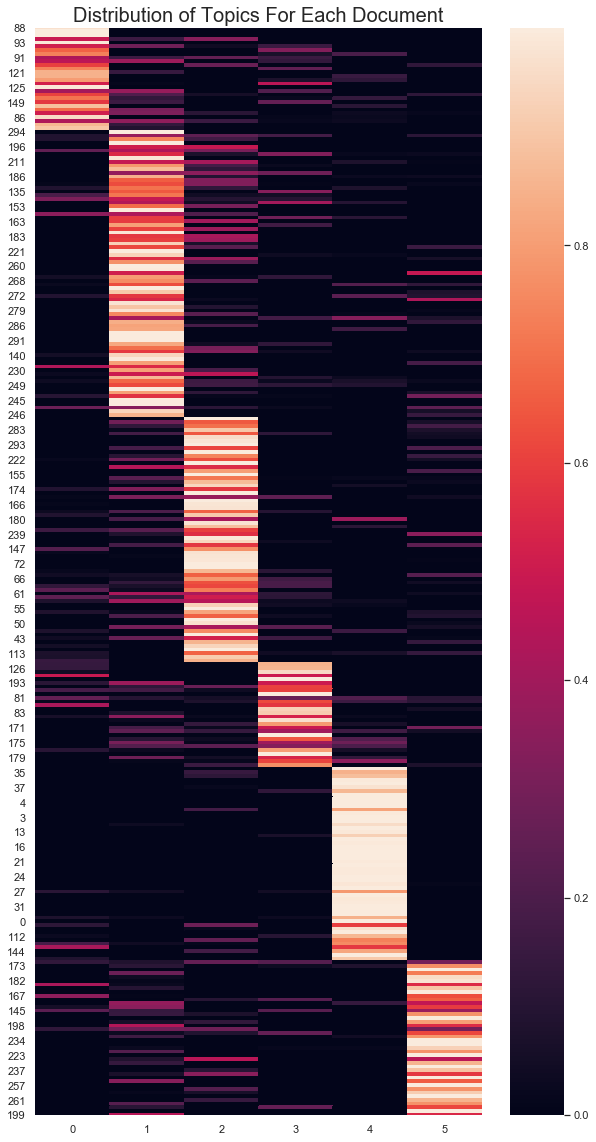

In [12]:
import pandas as pd
num_topics=6
topics = [lda[corpus[i]] for i in range(len(docs))]
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

#Visualization of the proportion of topics in the documents (Documents are rows, topic are columns). Sum of proportion across rows will add up to 1.
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index]) 
plt.title("Distribution of Topics For Each Document", fontsize =20)

### Documents Most Pertinent to Each Topic

In [13]:
#For each topic, which documents are most about that topic? 
for i in range(num_topics):
    print(document_topic.sort_values(i, ascending=False)[i].head(20))


99     0.999558
100    0.999525
125    0.995192
93     0.991375
88     0.971581
86     0.959624
123    0.899231
87     0.886606
137    0.862855
96     0.848396
121    0.847940
95     0.800117
89     0.740561
77     0.737015
128    0.708941
133    0.690410
110    0.670110
206    0.606047
90     0.597721
149    0.580030
Name: 0, dtype: float64
294    0.999386
241    0.999108
290    0.999091
291    0.999091
270    0.998935
245    0.998213
260    0.998057
221    0.997642
244    0.996782
187    0.996406
289    0.996025
248    0.994331
185    0.993679
262    0.993606
181    0.987437
204    0.985496
279    0.980198
275    0.978973
140    0.942188
247    0.940818
Name: 1, dtype: float64
266    0.999869
200    0.999624
51     0.999548
47     0.999155
293    0.999053
155    0.998837
71     0.998635
48     0.998410
216    0.998370
254    0.998354
267    0.998256
55     0.996918
72     0.996587
195    0.988834
73     0.987356
46     0.984027
166    0.983749
148    0.981302
162    0.979439
154    0

### Topic Frequency Among Documents

Text(0.5, 1.0, 'Topic Representation Frequency')

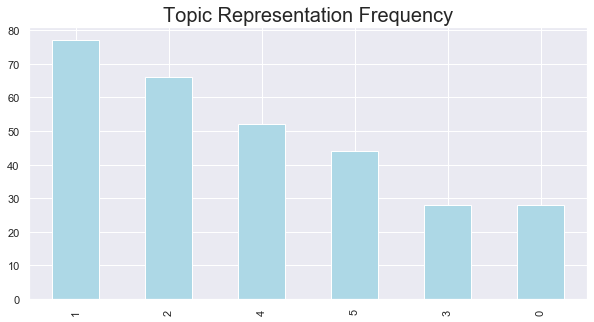

In [14]:
#Find out which topic is the most represented topic among documents. Topic 1 has the greatest number of documents that are the most related to topic 1. 
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')
plt.title("Topic Representation Frequency", fontsize =20)

References:
1. https://www.kdnuggets.com/2019/09/overview-topics-extraction-python-latent-dirichlet-allocation.html 
2. https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb
3. https://towardsdatascience.com/topic-modeling-with-gensim-a5609cefccc